In [1]:
import numpy as np
from scipy.stats import poisson
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
# from skgarden import RandomForestQuantileRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from datetime import datetime

import argparse
import pickle
import seaborn as sns
import os
from descartes import PolygonPatch
import alphashape

from scipy.stats import multivariate_normal

## Confidence Regions (Poster Figure)

In [2]:
directory = 'sims/camelus_linc/'
files = [x for x in os.listdir(directory) if 'pkl' in x and 'MLP6' in x]
files

['2d_confint_camelus_b_500000_bprime_50000_n25_MLP6_7_0.1_pytorch_2020-02-10.pkl',
 '2d_confint_camelus_b_500000_bprime_50000_n1_MLP6_7_0.1_pytorch_2020-02-10.pkl',
 '2d_confint_camelus_b_500000_bprime_50000_n10_MLP6_7_0.1_pytorch_2020-02-10.pkl']

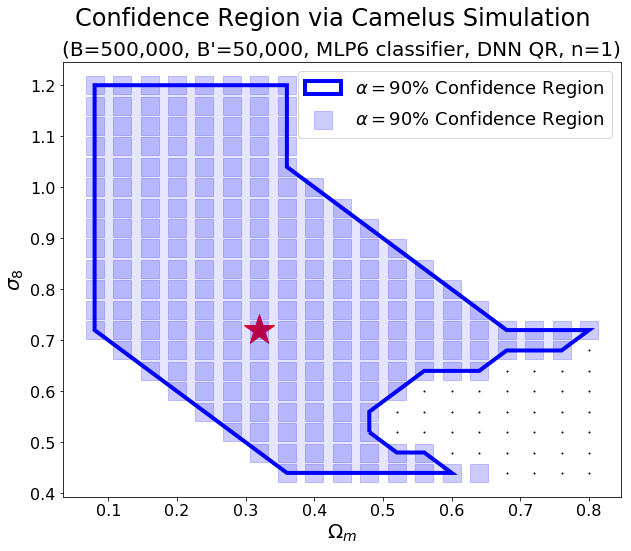

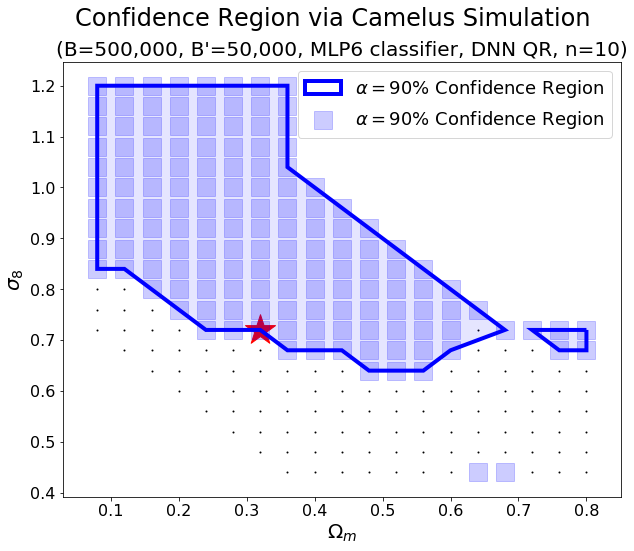

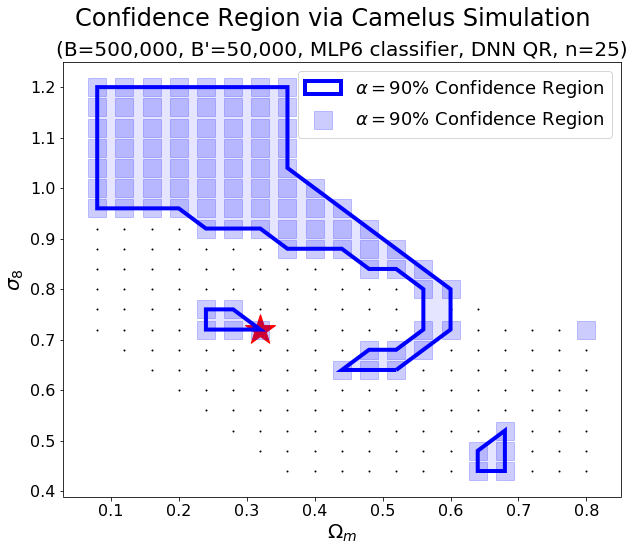

In [4]:
c_star = False
t0_val = [98, 10]
sample_size_obs = 1
t0_val = [0.32, 0.72]
alpha_val_hull = 20

for flnm in sorted(files, key= lambda x: int(x.split('_')[7].replace('n', ''))):
    
    b = int(flnm.split('_')[4])
    b_prime = int(flnm.split('_')[6])
    classifier = flnm.split('_')[8]
    sample_size_obs = int(flnm.split('_')[7].replace('n', ''))
    data_dict = pickle.load(open(directory + flnm, 'rb'))
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)
    plot_df = pd.DataFrame.from_dict({
        'background': data_dict['background'],
        'signal': data_dict['signal'],
        'tau_statistics': data_dict['tau_statistics'],
        'simul_nh_cutoff': np.array(data_dict['simul_nh_cutoff']).reshape(-1, ),
        'simul_nh_decision': np.array(data_dict['simul_nh_decision']).reshape(-1, )
                        #(data_dict['tau_statistics'] <= 
                        #np.array(data_dict['simul_nh_cutoff']).reshape(-1,)[1]).astype(int)
    })
    

    plot_df_in = plot_df[plot_df['simul_nh_decision'] == 0]
    points = np.hstack((plot_df_in['background'].values.reshape(-1,1),
                        plot_df_in['signal'].values.reshape(-1,1)))
    alpha_shape = alphashape.alphashape(points, alpha=alpha_val_hull)
    
    plt.scatter(x=t0_val[0], y=t0_val[1], color='r', marker='*', s=1000)
    ax.scatter(plot_df[plot_df['simul_nh_decision'] == 1]['background'].values, 
               plot_df[plot_df['simul_nh_decision'] == 1]['signal'].values, s=1, color='k')
    ax.scatter(plot_df[plot_df['simul_nh_decision'] == 0]['background'].values, 
               plot_df[plot_df['simul_nh_decision'] == 0]['signal'].values, s=350, 
               color='b', marker='s', alpha=0.2, label=r'$\alpha=90\%$ Confidence Region')

    ax.add_patch(PolygonPatch(alpha_shape, alpha=1, fill=None,
                              linewidth=4,
                              color='blue', label=r'$\alpha=90\%$ Confidence Region'))
    ax.add_patch(PolygonPatch(alpha_shape, alpha=0.1,
                              color='blue'))

    plt.xlabel(r'$\Omega_m$', fontsize=20)
    plt.ylabel(r'$\sigma_8$', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.suptitle('Confidence Region via Camelus Simulation', fontsize=24, y=0.975)
    plt.title("(B=%s, B'=%s, %s, n=%s)" % (
        '{:,}'.format(b), '{:,}'.format(b_prime),
        '%s classifier, DNN QR' % (classifier if 'XGBoost' not in classifier else 'XGBoost'),
        sample_size_obs), fontsize=20)
    plt.legend(loc='upper right', fontsize=18)
    image_name = '2d_confint_linc_b_%s_bprime_%s_n%s_%s_%s.pdf' % (
        b, b_prime, sample_size_obs, classifier,
        datetime.strftime(datetime.today(), '%Y-%m-%d'))
    plt.savefig('images/camelus_linc/' + image_name, bbox_inches='tight')
    plt.show()

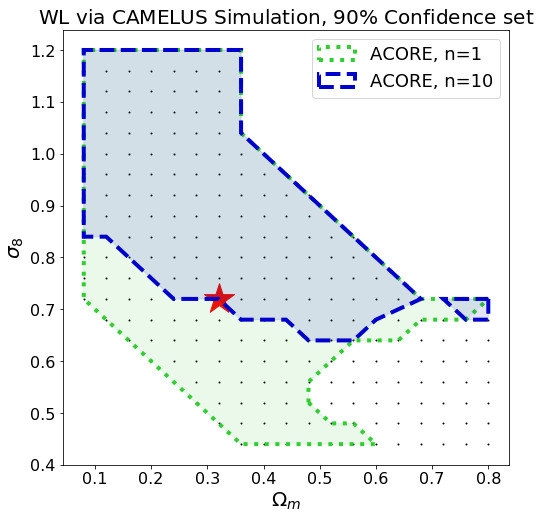

In [7]:
c_star = False
t0_val = [98, 10]
sample_size_obs = 1
t0_val = [0.32, 0.72]
alpha_val_hull = 20

label_vec = [r"ACORE, n=1",
                r"ACORE, n=10",
                r"ACORE, n=25"]
color_vec = ['limegreen', 'mediumblue', 'purple']
lt_vec = ['dotted', 'dashed', 'dashdot']


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
for kk, flnm in enumerate(sorted(files, key= lambda x: int(x.split('_')[7].replace('n', '')))[:2]):
    
    b = int(flnm.split('_')[4])
    b_prime = int(flnm.split('_')[6])
    classifier = flnm.split('_')[8]
    sample_size_obs = int(flnm.split('_')[7].replace('n', ''))
    data_dict = pickle.load(open(directory + flnm, 'rb'))

    plot_df = pd.DataFrame.from_dict({
        'background': data_dict['background'],
        'signal': data_dict['signal'],
        'tau_statistics': data_dict['tau_statistics'],
        'simul_nh_cutoff': np.array(data_dict['simul_nh_cutoff']).reshape(-1, ),
        'simul_nh_decision': np.array(data_dict['simul_nh_decision']).reshape(-1, )
    })
    

    plot_df_in = plot_df[plot_df['simul_nh_decision'] == 0]
    points = np.hstack((plot_df_in['background'].values.reshape(-1,1),
                        plot_df_in['signal'].values.reshape(-1,1)))
    alpha_shape = alphashape.alphashape(points, alpha=alpha_val_hull)
    
    if kk == 0:
        ax.scatter(plot_df['background'].values, plot_df['signal'].values, s=1, color='k')
    

    ax.add_patch(PolygonPatch(alpha_shape, alpha=1, fill=None,
                              linewidth=4, linestyle=lt_vec[kk],
                              color=color_vec[kk], label=label_vec[kk]))
    ax.add_patch(PolygonPatch(alpha_shape, alpha=0.1,
                              color=color_vec[kk]))
    
plt.scatter(x=t0_val[0], y=t0_val[1], color='r', marker='*', s=1000)
plt.xlabel(r'$\Omega_m$', fontsize=20)
plt.ylabel(r'$\sigma_8$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('WL via CAMELUS Simulation, $90\%$ Confidence set', fontsize=20)
plt.legend(loc='upper right', fontsize=18)
image_name = '2d_full_confint_linc_b_%s_bprime_%s_n%s_%s_%s.pdf' % (
    b, b_prime, sample_size_obs, classifier,
    datetime.strftime(datetime.today(), '%Y-%m-%d'))
plt.savefig('images/camelus_linc/' + image_name, bbox_inches='tight')
plt.show()

## Practical Strategy

In [8]:
directory = 'sims/camelus_linc/'
files = [x for x in os.listdir(directory) if '.csv' in x and 'b_analysis' in x and 'bmax' in x]
files

['b_analysis_camelus_alpha0-1_sizecheck1000_bmax500000.0_2020-02-10.csv']

              classifier  entropy_loss
17  XGBoost--(d5,-n1000)      0.450185
15  XGBoost--(d10,-n100)      0.471827
14                   QDA      0.487091
10                  MLP6      0.500988
12                  MLP8      0.501845
16  XGBoost--(d3,-n1000)      0.515052
13                    NN      0.571063
8                   MLP4      0.603157
11                  MLP7      0.616816
6                   MLP2      0.624869


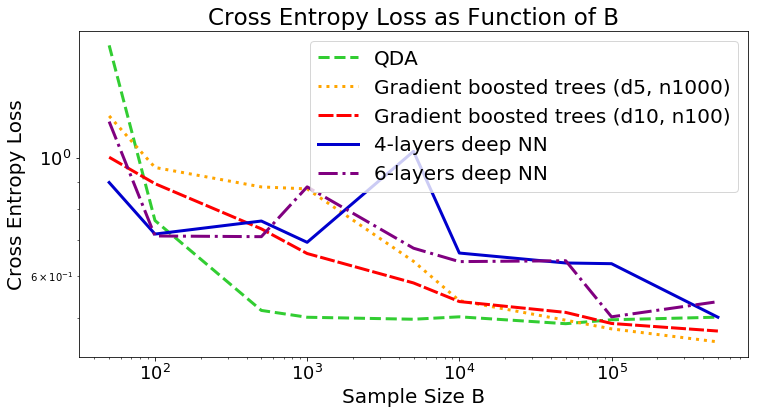

               classifier       b  entropy_loss
141  XGBoost--(d5,-n1000)  500000      0.450185
123  XGBoost--(d10,-n100)  500000      0.471827
140  XGBoost--(d5,-n1000)  100000      0.476319
112                   QDA   50000      0.487091
122  XGBoost--(d10,-n100)  100000      0.487591
139  XGBoost--(d5,-n1000)   50000      0.494510
113                   QDA  100000      0.495473
110                   QDA    5000      0.496607
109                   QDA    1000      0.500896
80                   MLP6  500000      0.500988
114                   QDA  500000      0.501101
111                   QDA   10000      0.501833
97                   MLP8  100000      0.501845
121  XGBoost--(d10,-n100)   50000      0.511519
129  XGBoost--(d3,-n1000)   10000      0.515052
108                   QDA     500      0.515959
131  XGBoost--(d3,-n1000)  100000      0.516415
132  XGBoost--(d3,-n1000)  500000      0.520442
130  XGBoost--(d3,-n1000)   50000      0.523940
98                   MLP8  500000      0

In [13]:
label_dict = {'QDA': 'QDA',
              'MLP6': '4-layers deep NN',
              'MLP8': '6-layers deep NN', 
              'XGBoost--(d5,-n1000)': 'Gradient boosted trees (d5, n1000)',
              'XGBoost--(d10,-n100)': 'Gradient boosted trees (d10, n100)'}
color_dict = {'QDA': 'limegreen', 
              'MLP6': 'mediumblue', 
              'MLP8': 'purple', 
              'XGBoost--(d5,-n1000)': 'orange',
              'XGBoost--(d10,-n100)': 'red'}
lt_dict = {'QDA': 'dashed', 
          'MLP6': 'solid', 
          'MLP8': 'dashdot', 
          'XGBoost--(d5,-n1000)': 'dotted',
          'XGBoost--(d10,-n100)': (0, (5, 1))}

for flnm in files:
    out_df = pd.read_csv(directory + flnm).set_index('Unnamed: 0')
    
    top_n_classifiers = 5
    class_vec = out_df.groupby(['classifier']).agg({'entropy_loss': np.min}).reset_index().sort_values(
        by='entropy_loss', ascending=True)['classifier'].values[:top_n_classifiers]
    
    print(out_df.groupby(['classifier']).agg({'entropy_loss': np.min}).reset_index().sort_values(
        by='entropy_loss', ascending=True).head(10))
    
    plt.figure(figsize=(12,6))
    plot_df = out_df[(out_df['classifier'].isin(class_vec)) & (out_df['b'] >= 50)]
    for jj, classifier in enumerate(plot_df['classifier'].unique()):
        temp_df = plot_df[plot_df['classifier'] == classifier].sort_values('b')
        ax = sns.lineplot(x=np.array(temp_df['b'].values).astype(float),
                y=np.array(temp_df['entropy_loss'].values).astype(float),
                label=label_dict[classifier], linewidth=3,
                color=color_dict[classifier])
        ax.lines[jj].set_linestyle(lt_dict[classifier])

    plt.xlabel('Sample Size B', fontsize=20)
    plt.ylabel('Cross Entropy Loss', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc='upper right', fontsize=20)
    #plt.ylim([0.5, 1])
    plt.yscale('log')
    plt.title('Cross Entropy Loss as Function of B', fontsize=23)
    outfile_name = 'cross_entropy_loss_across_b_%s.pdf' % datetime.strftime(datetime.today(), '%Y-%m-%d')
    plt.savefig('images/camelus_linc/' + outfile_name)
    plt.show()
    
    print(out_df.groupby(['classifier', 'b']).agg({'entropy_loss': np.min}).reset_index().sort_values(
        by='entropy_loss', ascending=True).head(20))

In [22]:
directory = 'sims/camelus_linc/'
files = [x for x in os.listdir(directory) if '.csv' in x and 'b_prime' in x and 'logregint' in x]
files

['b_prime_analysis_camelus_QDA_alpha0-1_ngrid101_sizecheck1000_logregint_2020-02-10.csv',
 'b_prime_analysis_camelus_MLP6_alpha0-1_ngrid101_sizecheck1000_logregint_2020-02-10.csv']

QDA
MLP6


/Users/NicDalmasso/python3_envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/NicDalmasso/python3_envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


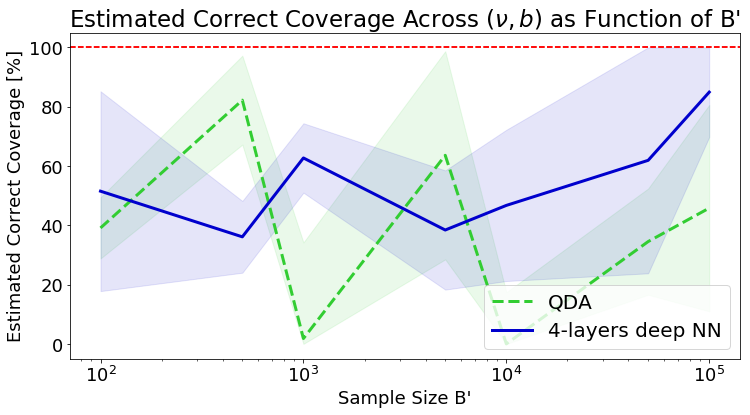

In [23]:
label_dict = {'QDA': 'QDA', 
              'MLP6': '4-layers deep NN', 
              'MLP2': '3-layers deep NN',
              'XGBoost--(d3,-n500)': 'Gradient boosted trees'}
color_dict = {'QDA': 'limegreen', 
              'MLP6': 'mediumblue', 
              'MLP2':'purple',
              'XGBoost--(d3,-n500)': 'red'}
lt_dict = {'QDA': 'dashed', 
          'MLP6': 'solid', 
          'MLP2':'dashdot',
          'XGBoost--(d3,-n500)': 'dotted'}

fig = plt.figure(figsize=(12,6))
for jj, flnm in enumerate(files):
    out_df = pd.read_csv(directory + flnm).set_index('Unnamed: 0')
    classifier = flnm.split('_')[4]
    print(classifier)

    top_n_classifiers = 3
    class_vec = out_df.groupby(['class_cde']).agg({'percent_correct_coverage': np.max}).reset_index().sort_values(
        by='percent_correct_coverage', ascending=False)['class_cde'].values[:top_n_classifiers]

    plot_df = out_df[(out_df['class_cde'] == 'pytorch')]
    plot_df['percent_correct_coverage_lr_perc'] = plot_df['percent_correct_coverage_lr'].apply(lambda x: x*100)
    
    mean_value = plot_df.sort_values('b_prime')['percent_correct_coverage_lr'].values*100
    upper_bound = plot_df.sort_values('b_prime')['percent_correct_coverage_1std'].values*100
    lower_bound = np.clip(mean_value - (upper_bound - mean_value), a_min=0, a_max=100)

    plt.axhline(y=100, linestyle='--', color='red')
    ax = sns.lineplot(x='b_prime', y='percent_correct_coverage_lr_perc', data=plot_df,
                label=label_dict[classifier], color=color_dict[classifier], linewidth=3)
    ax.lines[(2*jj) + 1].set_linestyle(lt_dict[classifier])
    plt.fill_between(x=plot_df.sort_values('b_prime')['b_prime'].values,
                     y2=upper_bound, y1=lower_bound, color=color_dict[classifier], alpha=0.1)
    
plt.xlabel("Sample Size B'", fontsize=18)
plt.ylabel('Estimated Correct Coverage [%]', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=20)
plt.xscale('log')
locs, labels = plt.xticks()
#plt.xlim([450, 200000])

plt.title(r"Estimated Correct Coverage Across $(\nu, b)$ as Function of B'", fontsize=23)
outfile_name = 'correct_coverage_diagnostic_%s.pdf' % datetime.strftime(datetime.today(), '%Y-%m-%d')
plt.savefig('images/camelus_linc/' + outfile_name)
plt.show()